In [108]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' #turn off the SettingWithCopyWarning
import numpy as np
import math

import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter
%matplotlib notebook

import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date, timedelta

# Example code for fixing the time issues (gmt to haw)

In [109]:
# #fix the gmt time issue

# df = pd.read_csv('hanalei_bridge_16103000.csv')
# df['datetime'] = pd.to_datetime(df['datetime'])
# df = df.set_index('datetime')

# df = df.tz_localize(None)         # Scrub out the Timezone awareness of the index 
# df = df.shift(-10, freq='H')             # Shift the timestamp back 10 hrs 
# df = df.reset_index()

# Read in the raw dataframe of stream gage and organize it for analysis

In [110]:
df_raw = pd.read_csv('Hanalei_stream_16103000_HAWAII-TIME.csv')
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
#only observing gage height
df_gage_height = df_raw[['datetime', 'metric_height_m', 'metric_discharge_cms']]
df_gage_height['standard_ft'] = df_gage_height.metric_height_m / 0.3048

C:\Users\bgorb\AppData\Local\Temp\ipykernel_31444\857097341.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('Hanalei_stream_16103000_HAWAII-TIME.csv')


# Resample data to max hourly to figure out where the peaks are

In [111]:
#resample to hourly based on the maximum recorded 
df_gage_height = df_gage_height.set_index('datetime')
df_gage_height.index = pd.to_datetime(df_gage_height.index)
df_gage_height =  df_gage_height.resample('H').max()
df_gage_height = df_gage_height.reset_index()

# Specify range of gage heights, and figure out dates where the gage peaked in this range

In [223]:
#specify gage height peak range
lower = 13.5
upper = 14.5


#run through the hourly dataset and find the recorded dates where the gage reached a peak between two values
peak_dates = []
peak_height = []
peak_date_index = []

for i in range(1, len(df_gage_height) -1):
    if df_gage_height.standard_ft[i] >= lower and df_gage_height.standard_ft[i] <= upper:
        if df_gage_height.standard_ft[i-1] < df_gage_height.standard_ft[i] and df_gage_height.standard_ft[i] > df_gage_height.standard_ft[i+1]:
            peak_dates.append(df_gage_height.datetime[i])
            peak_height.append(df_gage_height.standard_ft[i])
            peak_date_index.append(i)


# Figure out where the repetiive dates are and only observe the greatest peak value within the range

In [224]:
possible_indexes = list(df_gage_height.index)
peak_dates_verified = []
peak_heights_verified = []
accounting = []
total_flow_verified = []
for i in range(len(peak_date_index)):
    verification = 'NA'
    height_of_peak = peak_height[i]
    testing_peak_heights = []
    total_flow_sum = 0
    for y in range(peak_date_index[i]-48, peak_date_index[i]+48):
        if y not in possible_indexes:
            testing_peak_heights.append(1)
            continue
        if df_gage_height['standard_ft'][y] > height_of_peak:
            testing_peak_heights.append(1)
        else:
            testing_peak_heights.append(0)
        total_flow_sum += df_gage_height['metric_discharge_cms'][y]
            
        accounting.append(testing_peak_heights)
    if 1 in testing_peak_heights:
        verification = False
    else:
        verification = True
        peak_dates_verified.append(peak_dates[i])
        peak_heights_verified.append(peak_height[i])
        total_flow_verified.append(total_flow_sum)


Total number of gage height peaks in the range vs the number of true sole events

In [225]:
print(len(peak_date_index))
print(len(events))

2
28


# Combine all of the data into a dataframe for easy access

In [226]:
events = pd.DataFrame()
events['dates']  = peak_dates_verified
events['heights']  = peak_heights_verified
events['total_flow'] = total_flow_verified


events['start_date'] = np.nan
events['end_date'] = np.nan
for i in range(len(events)):
    events['start_date'][i] = events.dates[i] - timedelta(days=2)
    events['end_date'][i] = events.dates[i] + timedelta(days=2)
    
events =events.sort_values(by=['total_flow'], ascending = False)
events = events.reset_index(drop = True)

In [227]:
events[0:20]

dates  heights   total_flow           start_date  \
0 2020-03-17 08:00:00    14.10  7217.312910  2020-03-15 08:00:00   
1 2017-11-30 02:00:00    13.66  4520.784559  2017-11-28 02:00:00   

              end_date  
0  2020-03-19 08:00:00  
1  2017-12-02 02:00:00

# Plot the stream gage discharge data of the top 25% events to see which ones qualify based on distribution, peak, etc.

<IPython.core.display.Javascript object>


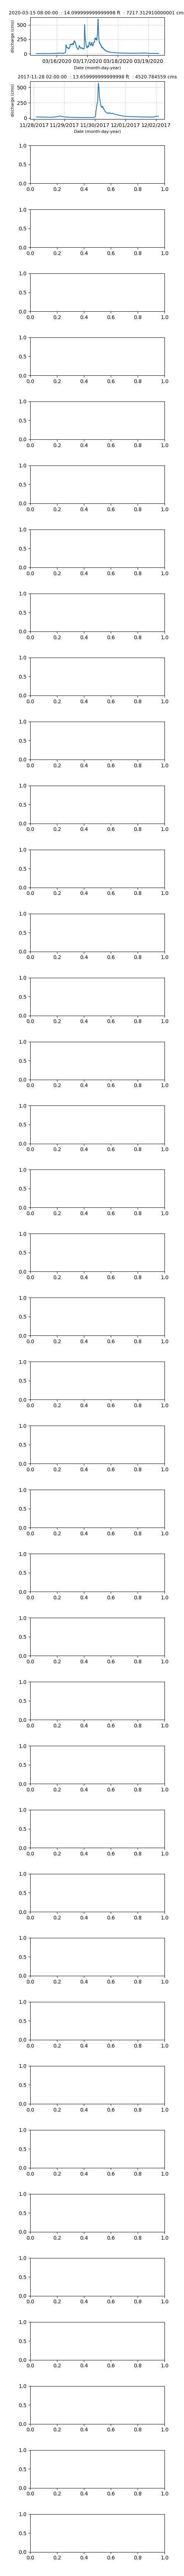

KeyError: 2

In [228]:
number_of_plots = 40
fig, axs= plt.subplots(number_of_plots, figsize=(5,70))
fig.tight_layout(pad=3.0)

for i in range(number_of_plots):
    start_date = events.start_date[i]
    end_date = events.end_date[i]
    
    filtered_df = df_raw.loc[(df_raw['datetime'] >= start_date) & (df_raw['datetime'] <= end_date)]
    axs[i].plot(filtered_df['datetime'], filtered_df['metric_discharge_cms'])
    
    axs[i].set_title(str(start_date) + '  : ' + str(events.heights[i]) + ' ft  : ' + str(events.total_flow[i]) + ' cms', fontsize = 9)
    axs[i].set_xlabel('Date (month-day-year)', fontsize = 8)
    axs[i].set_ylabel('discharge (cms)', fontsize = 8)
    axs[i].grid()
    myFmt = DateFormatter("%m-%d-%y")
    axs[i].xaxis.set_major_formatter(myFmt)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    axs[i].xaxis.set_major_locator(mdates.DayLocator())
    plt.rc('axes', axisbelow=True)
    axs[i].grid(True, color='gray', linestyle='dashed', alpha = 0.4)
